# **Superconductivity Regression Notebook**
Analyzes feature data from "*../data/features.csv*", which is produced in *get_featurizers.ipynb*. This is used to provide insight and guide optimzation of machine learning models created in the training notebooks. The machine learning models predict the critical temputure of superconductors.

*Author: Kirk Kleinsasser*

## Import Libraries / Define Import Data Function

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #confidence intervals for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as Superlearner

#try taking/ranking top ten features 

[MLENS] backend: threading


In [2]:
def get_poorcorr(threshold=0.1):
    assert 1.0 > threshold >= 0, "Threshold must be greater than or equal to 0 and less than 1.0"
    sfn.import_data(replace_inf=True) #import data with function above
    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(['HOMO_character','HOMO_element', 'LUMO_character', 'LUMO_element'], axis=1, inplace=True) #drop columns irrelevant to analysis
    graph_data['target'] = sfn.target.values #add target back in

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    target_corr = corr_matrix['target'] #gets target
    poor_corr = target_corr[(target_corr > -threshold) & (target_corr < threshold)]
    return poor_corr.index.values

In [3]:
poor_corr = get_poorcorr(0.05)

## Setup Arguments and Models

In [4]:
sfn.import_data(replace_inf=True)
#defines the arguments for each model
RFR_ARGS = {}
SP_ARGS = {'X': sfn.train_data}
KNN_ARGS = {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}
TREES_ARGS = {}
LIN_ARGS = {}

#defines the models in a list of pairs of lists. The first item in a pair is the top graph in a column, the second is the bottom. The last item of a model is to enable uncert calc
models  =  ((("Unoptimized Linear Regression", LinearRegression, {}, True),             ("Linear Regression", LinearRegression, LIN_ARGS, True)),
            (("Unoptimized Random Forest Regression", RandomForestRegressor, {}, True), ("Random Forest Regression", RandomForestRegressor, RFR_ARGS, True)),
            (("Unoptimized Extra Trees Regression", ExtraTreesRegressor, {}, True),     ("Extra Trees Regression", ExtraTreesRegressor, TREES_ARGS, True)),
            (("Unoptimized KNeighbors Regression", KNeighborsRegressor, {}, True),      ("KNeighbors Regression", KNeighborsRegressor, KNN_ARGS, True)))

warnings.filterwarnings('ignore') #got tired of non-converging errors

## Testing Correlation

Compare model with all features to ones with dropped extra features, using most models

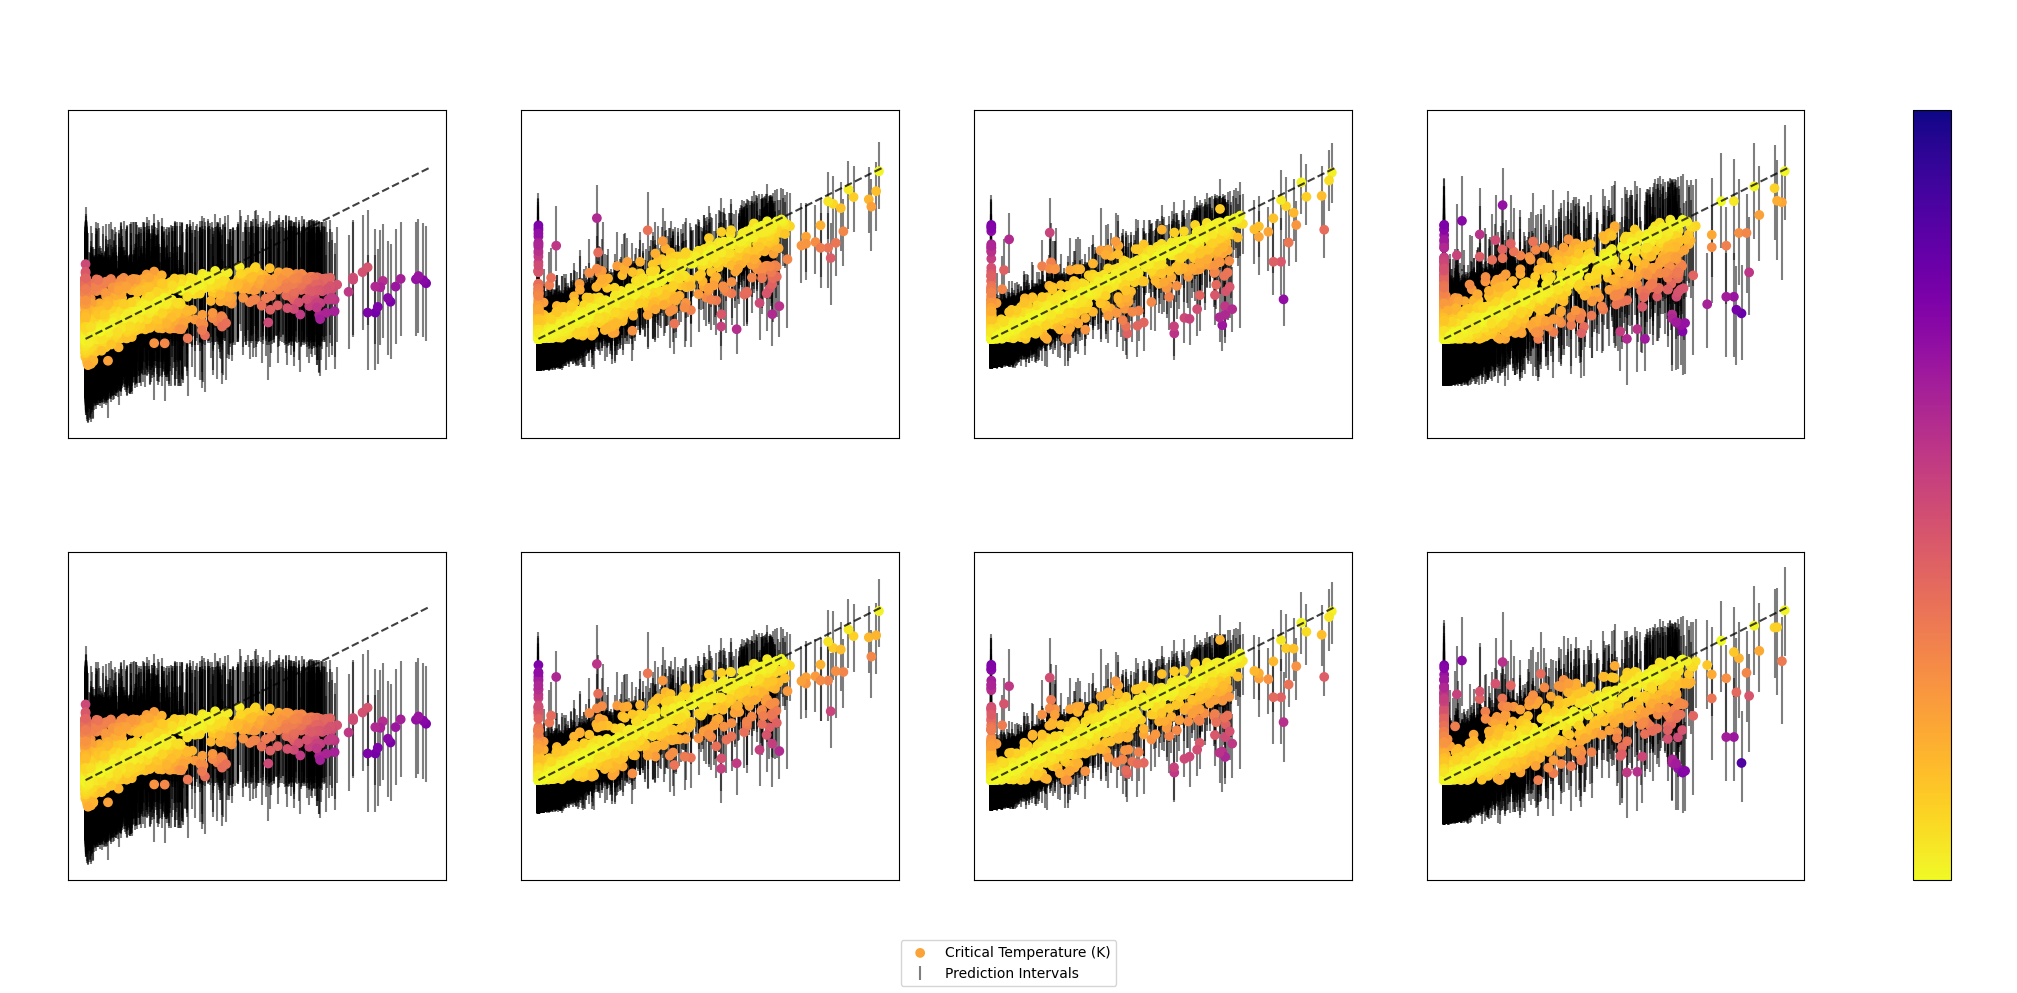

In [63]:
sfn.import_data(replace_inf=True)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - All Data", filename="results_optimized.png", export=False, forestci=False, method="plus")

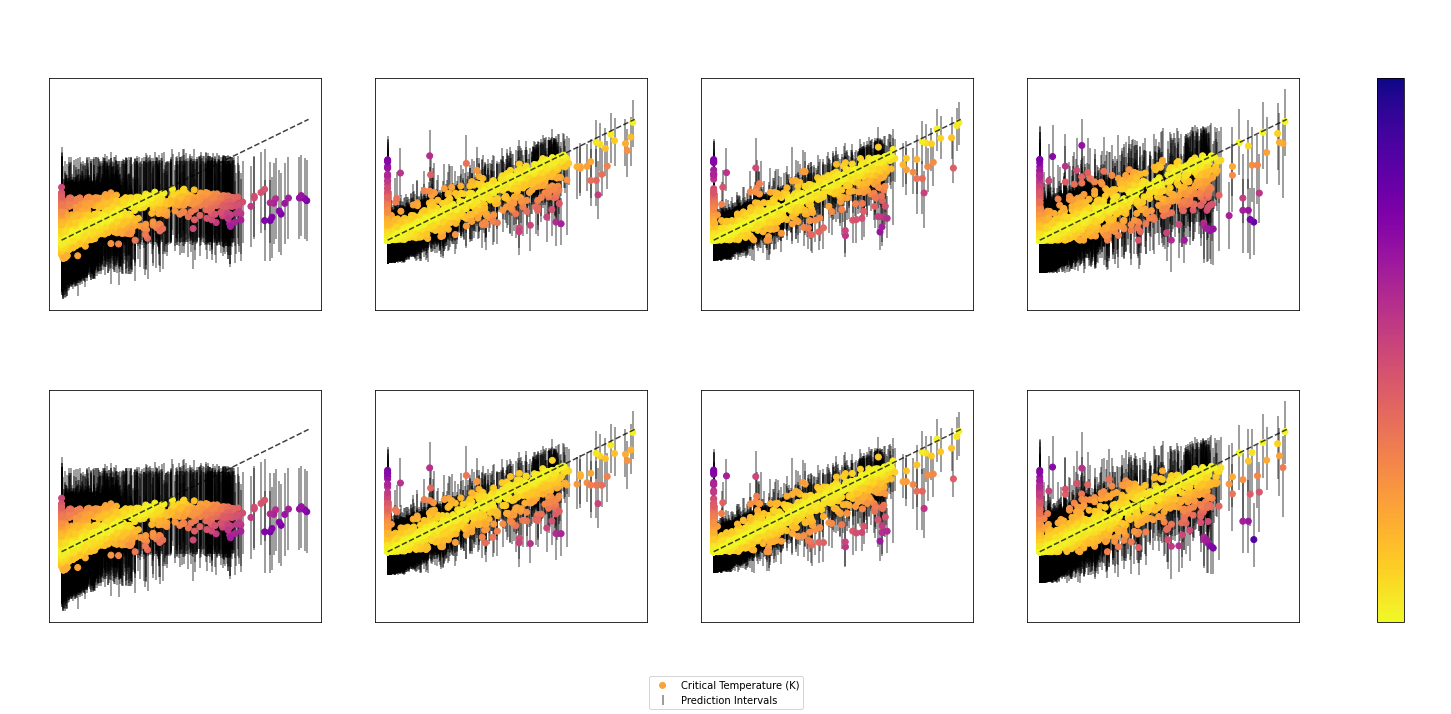

In [5]:
sfn.import_data(replace_inf=True, drop=poor_corr)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Selected Data", filename="results_optimized.png", export=False, forestci=False, method="plus")

## Feature Importance

In [4]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Decision Tree", DecisionTreeRegressor, {}, uncertainty=False, image=False, export_feat_importance=True, show=False)
sfn.evaluate_one("Random Forest", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, uncertainty=False, image=False, export_feat_importance=True, show=False)
sfn.evaluate_one("Extra Trees", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=False, image=False, export_feat_importance=True, show=False)

Starting training on Decision Tree
('Decision Tree', 268.236, 6.922, 124.6, 0.631, None)
Starting training on Random Forest
('Random Forest', 141.524, 5.821, 89.822, 0.805, None)
Starting training on Extra Trees
('Extra Trees', 132.333, 5.197, 90.085, 0.818, None)


<Figure size 432x288 with 0 Axes>

In [ ]:
dti = pd.read_csv('../data/importance/decision_tree_importance.csv').nlargest(10,'Importance') 
rfi = pd.read_csv('../data/importance/random_forest_importance.csv').nlargest(10,'Importance')
eti = pd.read_csv('../data/importance/extra_trees_importance.csv').nlargest(10,'Importance')

dtni = pd.read_csv('../data/importance/decision_tree_importance.csv').nsmallest(43,'Importance') 
rfni = pd.read_csv('../data/importance/random_forest_importance.csv').nsmallest(43,'Importance')
etni = pd.read_csv('../data/importance/extra_trees_importance.csv').nsmallest(43,'Importance')

In [ ]:
print("Decision Tree Top Features:")
display(dti)
print(dti.Feature.to_list())
print("\n\nRandom Forest Top Features:")
display(rfi)
print(rfi.Feature.to_list())
print("\n\nExtra Trees Top Features:")
display(eti)
print(eti.Feature.to_list())

Decision Tree Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.329939
1,MagpieData mean NUnfilled,0.119236
2,frac d valence electrons,0.045447
3,0-norm,0.033967
4,MagpieData mean MeltingT,0.032614
5,MagpieData mean NdValence,0.030728
6,2-norm,0.028992
7,MagpieData mean GSvolume_pa,0.028698
8,MagpieData mean CovalentRadius,0.028012
9,MagpieData mean NfUnfilled,0.020577


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', 'frac d valence electrons', '0-norm', 'MagpieData mean MeltingT', 'MagpieData mean NdValence', '2-norm', 'MagpieData mean GSvolume_pa', 'MagpieData mean CovalentRadius', 'MagpieData mean NfUnfilled']


Random Forest Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.326821
1,MagpieData mean NUnfilled,0.110788
2,0-norm,0.036726
3,frac d valence electrons,0.036146
4,MagpieData mean GSvolume_pa,0.026648
5,MagpieData mean MeltingT,0.025964
6,10-norm,0.024764
7,2-norm,0.024095
8,MagpieData mean CovalentRadius,0.021793
9,MagpieData mean NfUnfilled,0.020226


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', '0-norm', 'frac d valence electrons', 'MagpieData mean GSvolume_pa', 'MagpieData mean MeltingT', '10-norm', '2-norm', 'MagpieData mean CovalentRadius', 'MagpieData mean NfUnfilled']


Extra Trees Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.148171
1,MagpieData mean NUnfilled,0.079627
2,0-norm,0.065695
3,MagpieData mean SpaceGroupNumber,0.033278
4,MagpieData mean NfUnfilled,0.032505
5,MagpieData mean NdUnfilled,0.031588
6,MagpieData mean MeltingT,0.030618
7,frac p valence electrons,0.028310
8,MagpieData mean Electronegativity,0.026838
9,2-norm,0.026163


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', '0-norm', 'MagpieData mean SpaceGroupNumber', 'MagpieData mean NfUnfilled', 'MagpieData mean NdUnfilled', 'MagpieData mean MeltingT', 'frac p valence electrons', 'MagpieData mean Electronegativity', '2-norm']


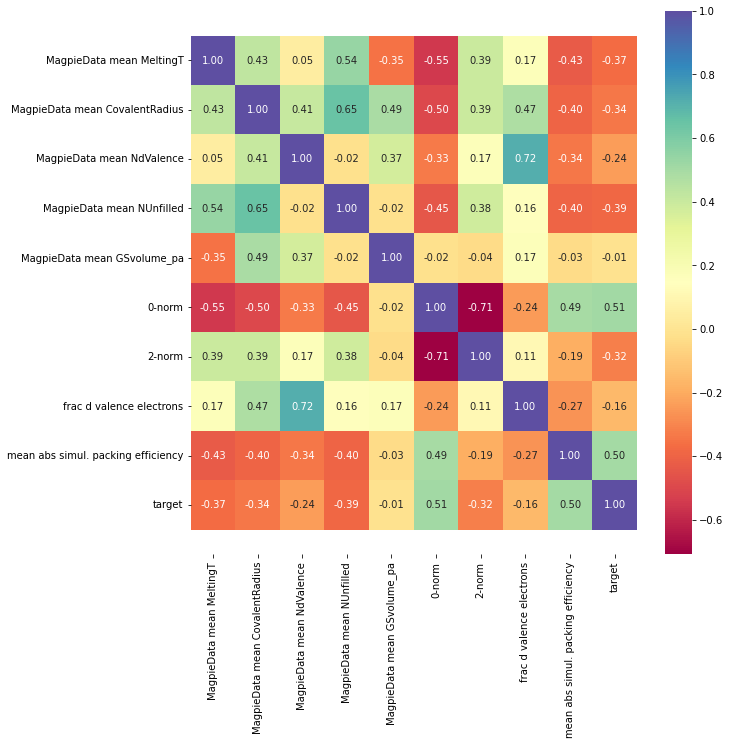

In [ ]:
def analysis(): #makes a heatmap that shows correlations between features and targets, saves to '../data/feature_heatmap.png'
    global corr_matrix
    sfn.import_data(replace_inf=True) #import data with function above

    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(dtni.Feature.to_list(), axis=1, inplace=True) #drop unimportant features
    graph_data['target'] = sfn.target.values #add target back in

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    fig, ax = plt.subplots(figsize=(10, 10)) #define figure and sizing features
    ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.color_palette("Spectral", as_cmap=True))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.tick_params(which='both') #set various colors

    #save heatmap
    figure = ax.get_figure()    
    figure.savefig('../data/feature_heatmap_eti.png', dpi=480) #saves to '../data/feature_heatmap.png' at 480 dpi
    
analysis() #calls function

Starting training on Decision Tree - Selected Features
('Decision Tree - Selected Features', 301.746, 7.509, 115.0, 0.585, 78.314)


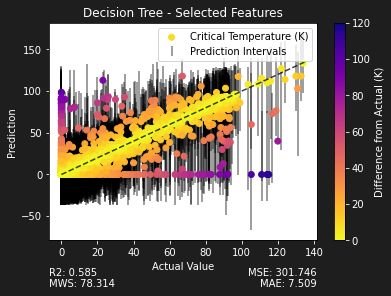

<Figure size 432x288 with 0 Axes>

In [ ]:
sfn.import_data(replace_inf=True, drop=dtni.Feature.to_list())
sfn.evaluate_one("Decision Tree - Selected Features", DecisionTreeRegressor, {}, uncertainty=True, method="plus", image=True)

Starting training on Random Forest - Selected Features
('Random Forest - Selected Features', 155.73, 6.229, 89.524, 0.786, 55.457)


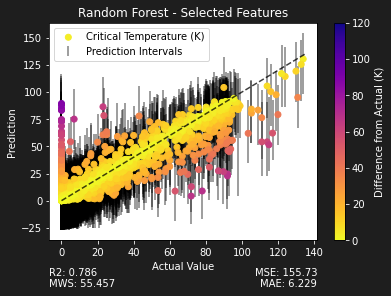

<Figure size 432x288 with 0 Axes>

In [18]:
sfn.import_data(replace_inf=True, drop=rfni.Feature.to_list())
sfn.evaluate_one("Random Forest - Selected Features", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, uncertainty=True, method="plus", image=True)

Starting training on Extra Trees - Selected Features
('Extra Trees - Selected Features', 150.414, 5.674, 101.809, 0.793, 51.129)


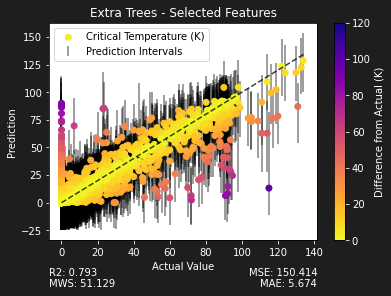

<Figure size 432x288 with 0 Axes>

In [19]:
sfn.import_data(replace_inf=True, drop=etni.Feature.to_list())
sfn.evaluate_one("Extra Trees - Selected Features", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=True, method="plus", image=True)

In [ ]:
#drop below top ten features for all models, or just bottom n features? Include full features in paper
#would report be a potential submission to arxiv

#aske about paper (arvix) later

#send tc beaking models

#essentially finish code tommorow, focus on presentation and paper next week